# Breast cancer data

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# read ST data


adata = sc.read_visium(path = '../patch', 
                       count_file='Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5', 
                       load_images=True)
adata.var_names_make_unique()
adata.var['SYMBOL'] = adata.var_names

library_id = list(adata.uns['spatial'].keys())[0]
 

C:\Users\qq135\Hist2Cell\venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\qq135\Hist2Cell\venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
print(adata.obsm['spatial'])
adata.obsm['spatial'] *= 2

[[199340 162650]
 [ 78930 185260]
 [187820  71780]
 ...
 [112290 182770]
 [ 94880 187800]
 [ 90560 149940]]


In [19]:
print(adata.obsm['spatial'])

[[398680 325300]
 [157860 370520]
 [375640 143560]
 ...
 [224580 365540]
 [189760 375600]
 [181120 299880]]


In [13]:
adata.obs.head()

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGCTTTCAGAAG-1,1,43,9
AAACAGGGTCTATATT-1,1,47,13


In [17]:
from PIL import Image
image_path = '../patch/tissue_hires_imageX20.png'
Image.MAX_IMAGE_PIXELS = None
image = Image.open(image_path)

# 将图像转换为 NumPy 数组（假设为 RGB 图像）
image_np = np.array(image)
Image.MAX_IMAGE_PIXELS = None
# 添加图像到 adata.uns['spatial'][library_id]['images'] 中
adata.uns['spatial'][library_id]['images']['full'] = image_np

In [20]:
# image size:
adata.uns["spatial"][library_id]["images"]["hires"].shape

(1839, 2000, 3)

MemoryError: Unable to allocate 32.9 GiB for an array with shape (36780, 40000, 3) and data type float64

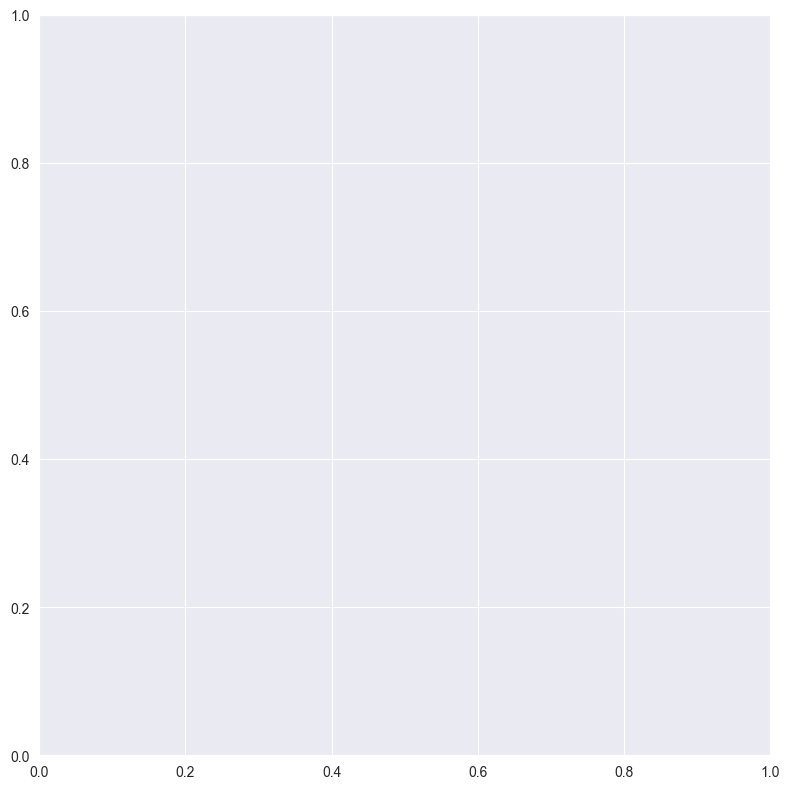

In [22]:

# sc.pl.spatial(adata,library_id=library_id)
img = sq.im.ImageContainer(
        adata.uns["spatial"][library_id]["images"]["full"][:,:,0:3],
        scale=adata.uns["spatial"][library_id]["scalefactors"]["tissue_hires_scalef"])

img.show(channelwise=False)

In [16]:
adata.uns["spatial"][library_id]["scalefactors"]

{'tissue_hires_scalef': 0.07285444,
 'tissue_lowres_scalef': 0.02185633,
 'fiducial_diameter_fullres': 304.61305842120373,
 'spot_diameter_fullres': 188.56998854645946}

In [17]:
adata.obs.shape

(2518, 3)

In [18]:
adata

AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL'
    uns: 'spatial'
    obsm: 'spatial'

In [19]:
# check if all spots are in tissue:
(adata.obs['in_tissue'] == 0).sum()

0

## ST data preprocessing

See a tutorial from here: https://scanpy.readthedocs.io/en/stable/tutorials/spatial/basic-analysis.html

Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.

In [20]:
adata

AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL'
    uns: 'spatial'
    obsm: 'spatial'

In [21]:
# Preserves the original data before any preprocessing steps.
adata_raw = adata.copy() # Store raw data  

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculates a number of qc metrics for an AnnData objec
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)




In [22]:
print(adata_raw)

AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL'
    uns: 'spatial'
    obsm: 'spatial'


In [23]:
print(adata)

AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'


In [24]:
# We found that there is no MT genes in the data  and therefore did not performa any gene filtering

adata.obs["pct_counts_mt"].unique()

array([0.], dtype=float32)

In [25]:
# normalization
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=250)


In [26]:
print(adata)

AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'



As you can see, following the above steps:
* 'highly_variable', 'means', 'dispersions', 'dispersions_norm' are now added to var, 



Now extract raw count data for highly variable genes. Note that adata.X is now log1p transformed but we store raw data in adata.raw

In [27]:
from scipy import sparse
# Get the indices of highly variable genes
highly_variable_genes = adata.var[adata.var['highly_variable']].index.tolist()

# Extract raw counts for highly variable genes
raw_counts_hvg = adata_raw[:, highly_variable_genes].X

# Extract log1p for highly variable genes
log1p_hvg = adata[:, highly_variable_genes].X

# Convert to dense array if needed
raw_counts_hvg = raw_counts_hvg.toarray() if sparse.issparse(raw_counts_hvg) else raw_counts_hvg
log1p_hvg = log1p_hvg.toarray() if sparse.issparse(log1p_hvg) else log1p_hvg

# Convert to DataFrame for easier handling
raw_counts_df = pd.DataFrame(raw_counts_hvg, index=adata.obs_names, columns=highly_variable_genes)
log1p_hvg_df = pd.DataFrame(log1p_hvg, index=adata.obs_names, columns=highly_variable_genes)

In [28]:
log1p_hvg_df.head()

,CSMD2,BEST4,FOXD2,COL11A1,HENMT1,HJV,S100A8,S100A2,OR10T2,ACKR1,...,TIMP3,HMOX1,POLR2F,WNT7B,MAGEB16,MTRNR2L10,AMER1,NOX1,TFDP3,MAGEA1
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,2.577862,0.0,0.0,0.000000,...,1.167061,1.691032,0.978102,0.440275,0.0,0.0,0.000000,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,2.226794,0.0,0.0,0.000000,...,1.636089,2.595639,1.120871,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.525336,0.0,0.0,0.641418,...,1.855521,0.000000,1.029028,0.000000,0.0,0.0,0.641418,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.138399,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.268171,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [29]:
raw_counts_df.head()

,CSMD2,BEST4,FOXD2,COL11A1,HENMT1,HJV,S100A8,S100A2,OR10T2,ACKR1,...,TIMP3,HMOX1,POLR2F,WNT7B,MAGEB16,MTRNR2L10,AMER1,NOX1,TFDP3,MAGEA1
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,...,4.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,...,6.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
## We keep all spots and therefore did not perform the basic filtering of spots based on total counts and expressed genes

# fig, axs = plt.subplots(1, 4, figsize=(15, 4))
# sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
# sns.histplot(
#     adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
#     kde=False,
#     bins=40,
#     ax=axs[1],
# )
# sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
# sns.histplot(
#     adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
#     kde=False,
#     bins=60,
#     ax=axs[3],
# )


# sc.pp.filter_cells(adata, min_counts=5000)
# sc.pp.filter_cells(adata, max_counts=35000)

## Get Patches

High-resolution tissue slides might be too large to fit in the memory. Therefore, we use a generator that produces cropped images from the original image container object. squidpy.im.ImageContainer.generate_spot_crops iterates over anndata.AnnData.obsm and extracts crops.

scale = 1 would crop the spot with exact diameter size. You can crop larger area by increasing the scale. 

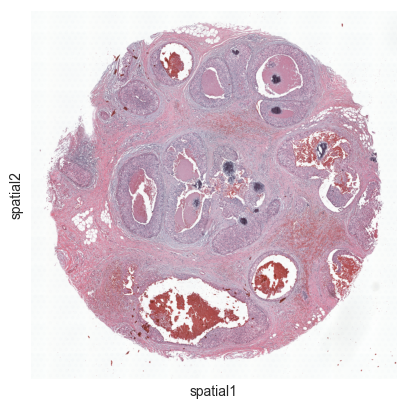

In [3]:
# original image
sc.pl.spatial(adata,library_id=library_id)

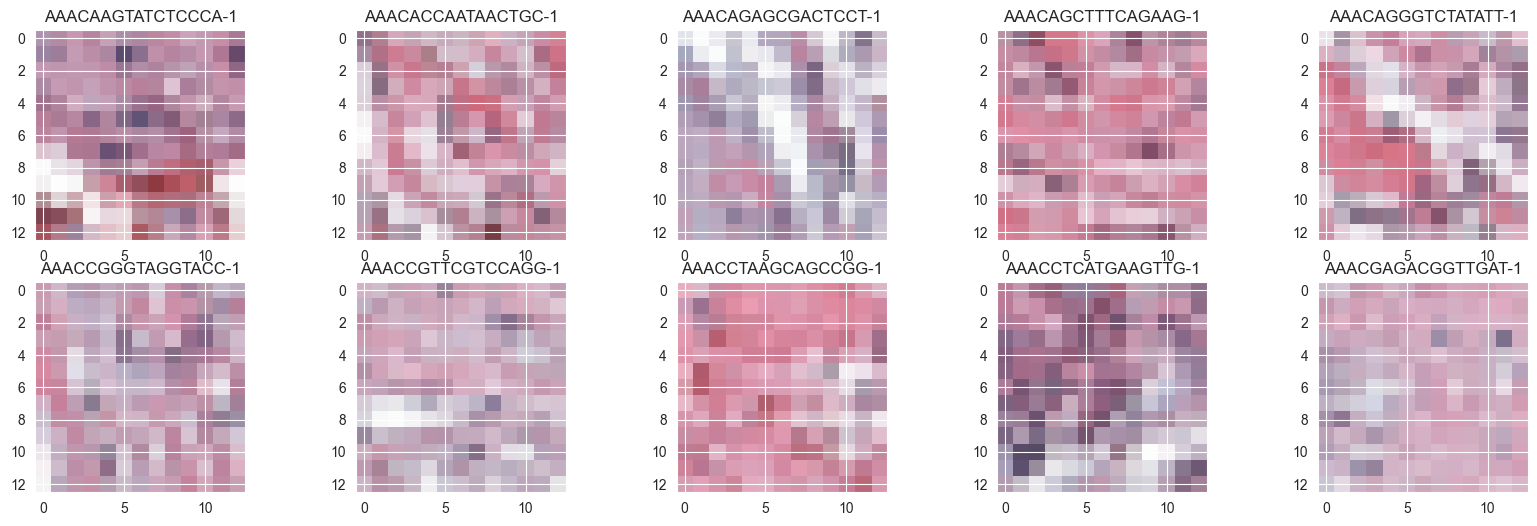

In [32]:
# a quick look, only set spot_scale to be 1

fig, axes = plt.subplots(2, 5)
axes = axes.flatten()
fig.set_size_inches((20, 6))
gen = img.generate_spot_crops(adata, spot_scale= 1,as_array = True,return_obs=True)
for i in range(10):
    image, obs_name = next(gen)
    axes[i].set_title(obs_name )
    axes[i].axis("on")
    axes[i].imshow(image['image'])

(61, 61, 3)


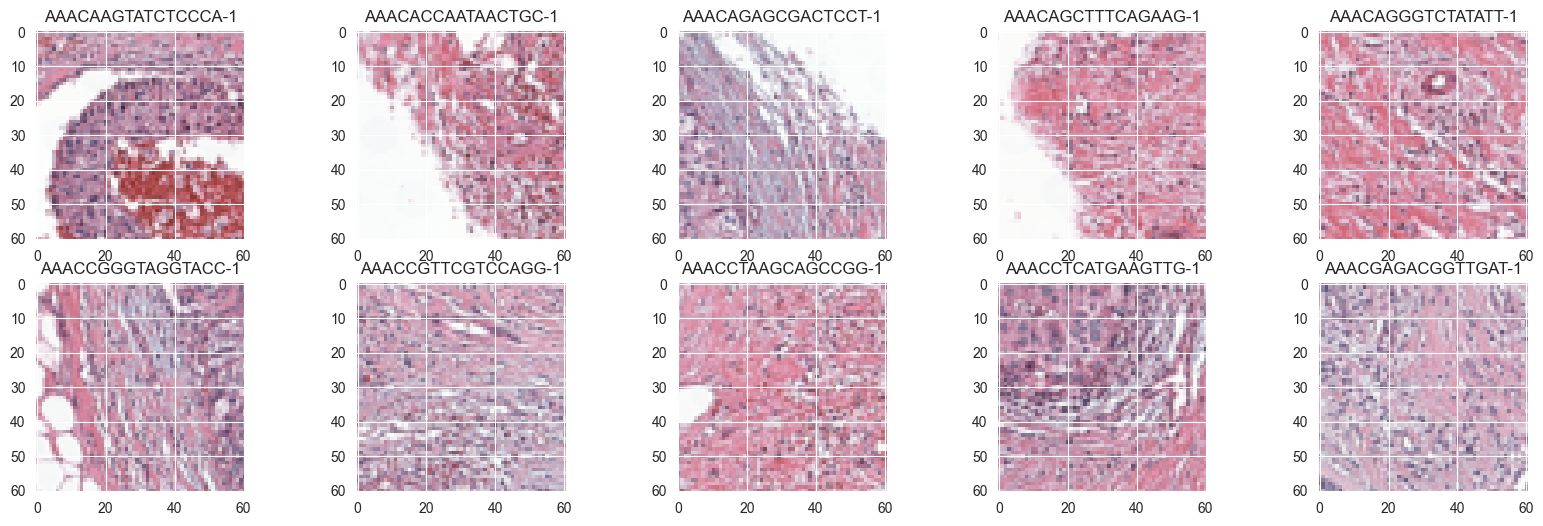

In [33]:
fig, axes = plt.subplots(2, 5)
axes = axes.flatten()
fig.set_size_inches((20, 6))
gen = img.generate_spot_crops(adata, spot_scale= 5,as_array = True,return_obs=True)
for i in range(10):
    image, obs_name = next(gen)
    if i==0:
        print(image['image'].shape)
    axes[i].set_title(obs_name )
    axes[i].axis("on")
    axes[i].imshow(image['image'])

(19, 19, 3)


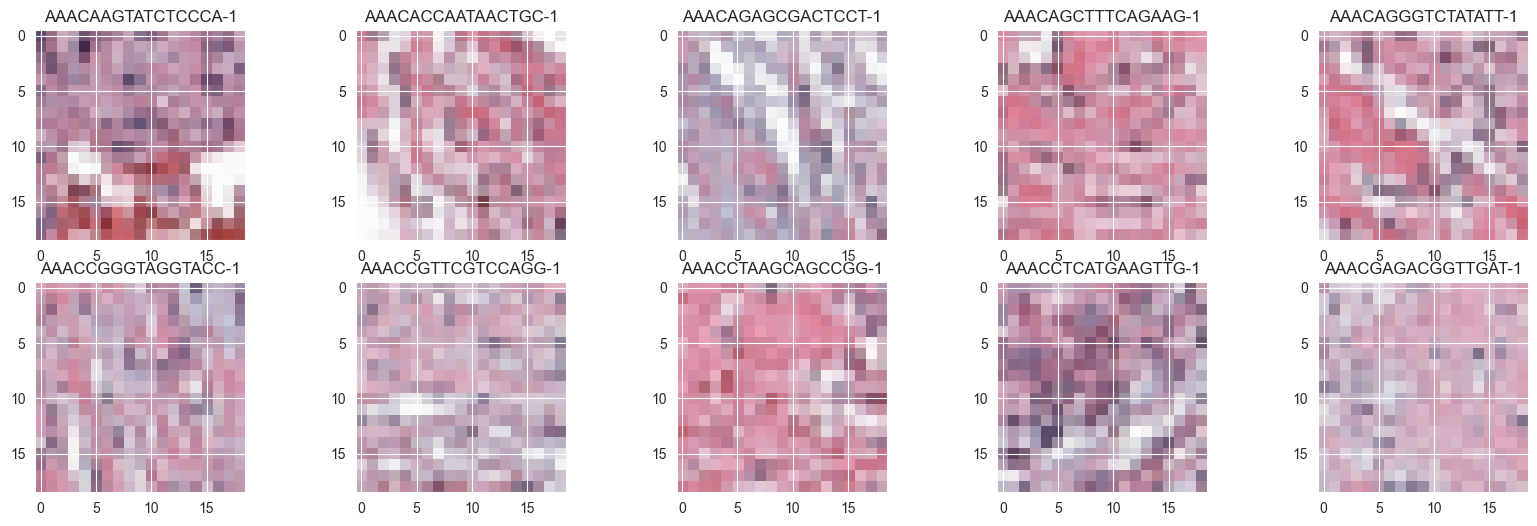

In [34]:
fig, axes = plt.subplots(2, 5)
axes = axes.flatten()
fig.set_size_inches((20, 6))
gen = img.generate_spot_crops(adata, spot_scale= 1.5,as_array = True,return_obs=True)
for i in range(10):
    image, obs_name = next(gen)
    if i==0:
        print(image['image'].shape)
    axes[i].set_title(obs_name )
    axes[i].axis("on")
    axes[i].imshow(image['image'])

(223, 223, 3)


IndexError: index 10 is out of bounds for axis 0 with size 10

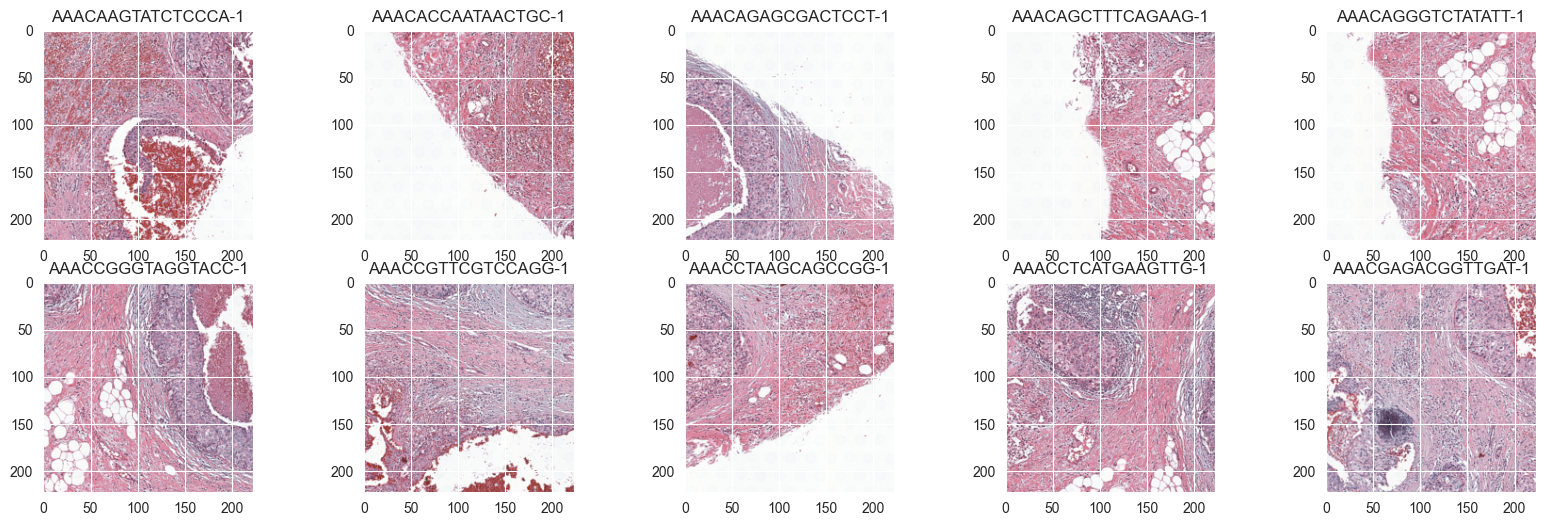

In [120]:

img = sq.im.ImageContainer(
        adata.uns["spatial"][library_id]["images"]["hires"][:,:,0:3],
        scale=adata.uns["spatial"][library_id]["scalefactors"]["tissue_hires_scalef"])

gen = img.generate_spot_crops(adata, spot_scale= 1.5,as_array = True,return_obs=True)
    # as_array = False, spot will be `ImageContainer`; as_array = False, spot will be anarray`;
    # obs is from `adata.obs_names`

patches = dict()
cnt = 0
for patch, obs in gen:
    if cnt ==0:
        print(patch['image'].shape)
    cnt+=1
    patches[obs] = patch['image']


In [123]:
cnt

AAACAAGTATCTCCCA-1
(223, 223, 3)


(223, 223, 3)


In [5]:
import os
from PIL import Image
save_dir = "../patch/output/patches"
img = sq.im.ImageContainer(
        adata.uns["spatial"][library_id]["images"]["hires"][:,:,0:3],
        scale=adata.uns["spatial"][library_id]["scalefactors"]["tissue_hires_scalef"])

gen = img.generate_spot_crops(adata, spot_scale= 1.5,as_array = True,return_obs=True)
    # as_array = False, spot will be `ImageContainer`; as_array = False, spot will be anarray`;
    # obs is from `adata.obs_names`

patches = dict()
cnt = 0
for patch, obs in gen:
    if cnt ==0:
        print(patch['image'].shape)
    cnt+=1
    image_array = np.clip(patch['image'] * 255, 0, 255).astype(np.uint8)
    # 转换为 Pillow 图像对象
    img_pil = Image.fromarray(image_array)

    # 保存图像
    file_path = os.path.join(save_dir, f'{obs}.png')
    img_pil.save(file_path)

(19, 19, 3)


In [46]:
img = sq.im.ImageContainer(
        adata.uns["spatial"][library_id]["images"]["hires"][:,:,0:3],
        scale=adata.uns["spatial"][library_id]["scalefactors"]["tissue_hires_scalef"])

gen = img.generate_spot_crops(adata, spot_scale= 1.5,as_array = True,return_obs=True)
    # as_array = False, spot will be `ImageContainer`; as_array = False, spot will be anarray`;
    # obs is from `adata.obs_names`

images = []
cnt = 0
for patch, obs in gen:
    if cnt ==0:
        print(patch['image'].shape)
    cnt+=1
    patches[obs] = patch['image']
    images.append(patch['image'])
images_array = np.array(images)


# 计算每个通道的平均值
mean_image = np.mean(images_array, axis=(0, 1, 2))
st_image = np.std(images_array, axis=(0, 1, 2))

(19, 19, 3)


In [47]:
print(mean_image)
print(st_image)

[0.75420076 0.6217488  0.6946153 ]
[0.11452981 0.15589917 0.14246847]


# Healthy lung data
Downloaded from: https://cellxgene.cziscience.com/collections/c1241244-b22d-483d-875b-75699efb9f3c

In [3]:
import scanpy as sc
import squidpy as sq

library_id = 'WSA_LngSP9258463'
adata = sc.read_h5ad("../example_data/" + "SP" +".h5ad")

In [4]:
# quite a lot of information has been stored in the downloaded data
adata

AnnData object with n_obs × n_vars = 12361 × 12912
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'Perichondrium', 'Weird_morphology', 'Cartilage', 'Glands', 'Tissue', 'Multilayer_epithelium', 'Nerve', 'Venous_vessel', 'Airway_Smooth_Muscle', 'Arterial_vessel', 'Parenchyma', 'Pulmonary_vessel', 'Mesothelium', 'Small_airway', 'iBALT', '_indices', '_scvi_batch', '_scvi_labels', 'AT1', 'AT2', 'B_memory', 'B_naive', 'B_plasma_IgA', 'B_plasma_IgG', 'B_plasmablast', 'Basal', 'CD4_EM_Effector', 'CD4_TRM', 'CD4_naive_CM', 'CD8_EM', 'CD8_EM_EMRA', 'CD8_TRM_EM', 'CD8_TRM', 'Chondrocyte', 'Ciliated', 'DC_1', 'DC_2', 'DC_activated', 'DC_plasmacytoid', 'Deuterosomal', 'Dividing_AT2', 'Dividing_Basal', 'Endothelia_Lymphatic', 'Endothelia_vascular_Cap_a', 'Endothelia_vascul

In [366]:
adata.obs.head(2)

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,region_cluster,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
AAACAACGAATAGTTC-1,0,0,16,WSA_LngSP9258467,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,unknown,Visium Spatial Gene Expression,normal,Homo sapiens,female,bronchus,European,eighth decade human stage,S{qkR!yc~8
AAACAAGTATCTCCCA-1,0,50,102,WSA_LngSP9258467,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,unknown,Visium Spatial Gene Expression,normal,Homo sapiens,female,bronchus,European,eighth decade human stage,gFD!+Zqd(i


In [26]:
# keys for unstructured data
adata.uns.keys()

dict_keys(['_scvi_manager_uuid', '_scvi_uuid', 'citation', 'means_cell_abundance_w_sf', 'mod', 'mod_coloc_n_fact11', 'mod_coloc_n_fact12', 'mod_coloc_n_fact13', 'mod_coloc_n_fact19', 'mod_coloc_n_fact20', 'mod_coloc_n_fact21', 'mod_coloc_n_fact22', 'mod_coloc_n_fact8', 'mod_coloc_n_fact9', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'schema_reference', 'schema_version', 'spatial', 'spatial_metadata', 'stds_cell_abundance_w_sf', 'title'])

In [5]:
# cell2location output is here:
adata.uns['q05_cell_abundance_w_sf'].shape

KeyError: 'q05_cell_abundance_w_sf'

In [370]:
adata.uns['q05_cell_abundance_w_sf'].head()

,q05cell_abundance_w_sf_AT1,q05cell_abundance_w_sf_AT2,q05cell_abundance_w_sf_B_memory,q05cell_abundance_w_sf_B_naive,q05cell_abundance_w_sf_B_plasma_IgA,q05cell_abundance_w_sf_B_plasma_IgG,q05cell_abundance_w_sf_B_plasmablast,q05cell_abundance_w_sf_Basal,q05cell_abundance_w_sf_CD4_EM_Effector,q05cell_abundance_w_sf_CD4_TRM,...,q05cell_abundance_w_sf_SMG_Duct,q05cell_abundance_w_sf_SMG_Mucous,q05cell_abundance_w_sf_SMG_Serous,q05cell_abundance_w_sf_Schwann_Myelinating,q05cell_abundance_w_sf_Schwann_nonmyelinating,q05cell_abundance_w_sf_Secretory_Club,q05cell_abundance_w_sf_Secretory_Goblet,q05cell_abundance_w_sf_Suprabasal,q05cell_abundance_w_sf_T_reg,q05cell_abundance_w_sf_gdT
spot_id,,,,,,,,,,,,,,,,,,,,,
WSA_LngSP9258467_AAACCGTTCGTCCAGG-1,0.138944,0.684961,0.024285,0.019018,0.005090,0.003046,0.004394,0.016751,0.028917,0.022988,...,0.001308,0.001877,0.002468,0.001117,0.010967,0.001754,0.099053,0.017590,0.018854,0.021031
WSA_LngSP9258467_AAATCGTGTACCACAA-1,0.000506,0.000076,0.095560,0.099559,0.001024,0.007057,0.355264,1.121668,0.087579,0.077751,...,0.002951,0.070211,0.000356,0.000642,0.019697,0.007914,1.401940,1.070314,0.060025,0.055936
WSA_LngSP9258467_AAATGGTCAATGTGCC-1,0.000277,0.000163,0.063559,0.029090,0.001344,0.039083,0.091218,0.024614,0.024625,0.024525,...,0.000343,0.000642,0.000080,0.000254,0.008571,0.000480,0.081795,0.011888,0.018368,0.025329
WSA_LngSP9258467_AAATTAACGGGTAGCT-1,0.000026,0.000007,0.038941,0.010351,0.000235,0.003664,0.377583,0.000794,0.012577,0.016248,...,0.000056,0.000008,0.000067,0.000162,0.151103,0.000669,0.001095,0.000197,0.005750,0.019536
WSA_LngSP9258467_AACAACTGGTAGTTGC-1,0.000301,0.000176,0.051775,0.021459,0.000415,0.013202,0.271362,0.029137,0.019969,0.018359,...,0.000292,0.000383,0.000036,0.000243,0.009423,0.000185,0.102825,0.034596,0.012205,0.017274


In [371]:
# H&E images
adata.uns["spatial"][library_id]["images"]["hires"]

array([[[238, 241, 244],
        [238, 241, 244],
        [238, 241, 244],
        ...,
        [238, 241, 244],
        [238, 241, 244],
        [238, 241, 244]],

       [[238, 241, 244],
        [238, 241, 244],
        [238, 241, 244],
        ...,
        [238, 241, 244],
        [238, 241, 244],
        [238, 241, 244]],

       [[238, 241, 244],
        [238, 241, 244],
        [238, 241, 244],
        ...,
        [238, 241, 244],
        [238, 241, 244],
        [238, 241, 244]],

       ...,

       [[238, 241, 244],
        [238, 241, 244],
        [238, 241, 244],
        ...,
        [238, 241, 244],
        [238, 241, 244],
        [238, 241, 244]],

       [[238, 241, 244],
        [238, 241, 244],
        [238, 241, 244],
        ...,
        [238, 241, 244],
        [238, 241, 244],
        [238, 241, 244]],

       [[238, 241, 244],
        [238, 241, 244],
        [238, 241, 244],
        ...,
        [238, 241, 244],
        [238, 241, 244],
        [238, 241, 244]]

In [51]:
adata.uns["spatial"][library_id]["images"]["hires"].shape

(1123, 2000, 3)

In [55]:
adata.uns["spatial"][library_id]["images"]["fullres"].shape

KeyError: 'fullres'

In [346]:
# cordinate of barcode
print(adata.obsm['spatial'].shape)

adata.obsm['spatial'][:5,:]

(4992, 2)


array([[11057,  2078],
       [20485, 11616],
       [14017,  2650],
       [11385, 13333],
       [19608,  4749]])

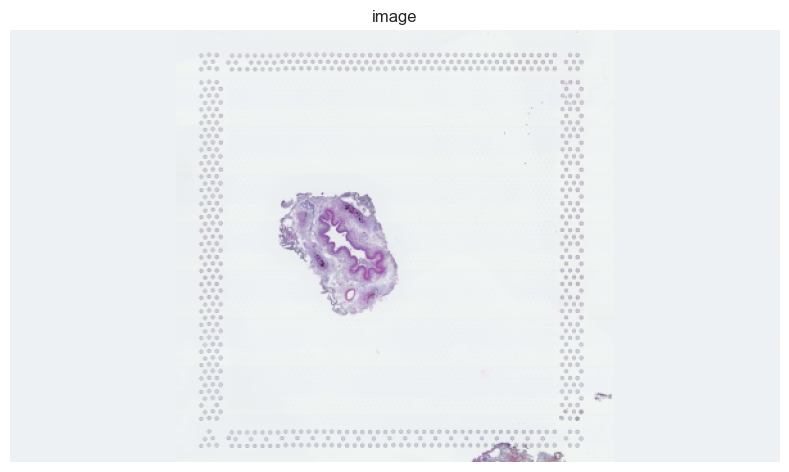

In [5]:

# sc.pl.spatial(adata,library_id=library_id)
library_id = "WSA_LngSP9258467"
img = sq.im.ImageContainer(
        adata.uns["spatial"][library_id]["images"]["lowres"][:,:,0:3],
        scale=adata.uns["spatial"][library_id]["scalefactors"]["tissue_lowres_scalef"])

img.show(channelwise=False)

In [48]:
imgdata = adata.uns["spatial"][library_id]["images"]["lowres"]
save_dir = "../example_data/testing"
image_array = np.clip(imgdata * 255, 0, 255).astype(np.uint8)
# 转换为 Pillow 图像对象
img_pil = Image.fromarray(image_array)

# 保存图像
file_path = os.path.join(save_dir, f'{"WSA_LngSP9258464"}.png')
img_pil.save(file_path)
img.save("../example_data/WSA_LngSP9258464_low_res.jpg")


array([[[0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        ...,
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ]],

       [[0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        ...,
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ]],

       [[0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        ...,
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ]],

       ...,

       [[0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0.93333334, 0.9372549 ],
        [0.94509804, 0

In [10]:
adata.uns["spatial"][library_id]["scalefactors"]

{'fiducial_diameter_fullres': 237.74751529903637,
 'spot_diameter_fullres': 147.17703328035586,
 'tissue_hires_scalef': 0.056960583,
 'tissue_lowres_scalef': 0.017088175}

Note that there are spots not in tissue (in_tissue ==0)

In [349]:
(adata.obs['in_tissue']!=0).sum()

436

In [356]:
# check ST data
adata.X.toarray() 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [358]:
adata.obs.loc[adata.obs.in_tissue==1,['array_row','array_col']].head()

,array_row,array_col
AAACCGTTCGTCCAGG-1,52,42
AAATCGTGTACCACAA-1,44,56
AAATGGTCAATGTGCC-1,33,51
AAATTAACGGGTAGCT-1,34,58
AACAACTGGTAGTTGC-1,28,42


In [103]:
# gene names
adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733',
       'ENSG00000235146',
       ...
       'ENSG00000277196', 'ENSG00000277630', 'ENSG00000278384',
       'ENSG00000278633', 'ENSG00000276345', 'ENSG00000277856',
       'ENSG00000275063', 'ENSG00000271254', 'ENSG00000277475',
       'ENSG00000268674'],
      dtype='object', name='gene_ids', length=33159)

# Load Hist2Cell preprocessed data

In the processed  data, the following varibales are:
- `x`: the 224 x 224 x 3 image patch for each spot in the ST data, each spot is considered as one node in the graphs representing the slide, there are in total 422 spots in this slide;
- `edge_index`: graph connectivity in `COO` format with shape `[2, num_edges]`, there are 2732 edges in this slide;
- `y`: the label for each spot, contains 250 highly expressed gene labels + 80 fine-grained cell abundance labels, resulting 330 labels for each spot;
- `pos`: the x-y pixel coordinate of each spot on the original slide, used in visualization and calculating cell-colocalization metric;

In [372]:
import torch


processed_data = torch.load("../example_data/humanlung_cell2location/" + library_id + ".pt")

/opt/anaconda3/envs/spatial/lib/python3.12/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/spatial/lib/python3.12/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.12/Python
  Referenced from: <7BF3ABB0-5875-3736-8AB2-1784D3EFB687> /opt/anaconda3/envs/spatial/lib/python3.12/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/anaconda3/envs/spatial/lib/python3.12/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen

In [373]:
processed_data

Data(x=[422, 3, 224, 224], edge_index=[2, 2732], y=[422, 330], pos=[422, 2])

In [374]:
processed_data['y']

tensor([[2.3157, 2.3157, 2.3157,  ..., 0.6244, 0.0350, 0.0278],
        [0.0000, 1.8449, 2.4558,  ..., 0.1782, 0.0317, 0.0265],
        [0.0000, 2.9745, 3.3628,  ..., 0.0559, 0.0311, 0.0387],
        ...,
        [0.0000, 2.3289, 2.1050,  ..., 3.0838, 0.0766, 0.0481],
        [2.4686, 0.0000, 0.0000,  ..., 0.0170, 0.0132, 0.0195],
        [4.2714, 0.0000, 4.2714,  ..., 0.0121, 0.0062, 0.0071]])

In [375]:
processed_data['x'].shape

torch.Size([422, 3, 224, 224])